In [15]:
! pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/300.2 kB 487.6 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 819.2 kB/s eta 0:00:01
   ---------------------------------- ----- 256.0/300.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
reviews_df = pd.read_csv('reviews.csv')
reviews_df.shape
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'])
min = reviews_df['review_date'].min()
max = reviews_df['review_date'].max()
print(min)
print(max)


1800-01-01 00:00:00
2020-10-29 00:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary NLTK data
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Load the datasets
reviews_df = pd.read_csv('reviews.csv')
movies_df = pd.read_csv('movies.csv')

# Merge datasets
df = pd.merge(reviews_df, movies_df, on='rotten_tomatoes_link', how='inner')

# Convert review_type to binary sentiment
df['sentiment'] = df['review_type'].map({'Fresh': 1, 'Rotten': 0})

# Display basic information about the dataset
print(df.info())
print(df['sentiment'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129887 entries, 0 to 1129886
Data columns (total 30 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   rotten_tomatoes_link              1129887 non-null  object 
 1   critic_name                       1111366 non-null  object 
 2   top_critic                        1129887 non-null  bool   
 3   publisher_name                    1129887 non-null  object 
 4   review_type                       1129887 non-null  object 
 5   review_score                      823985 non-null   object 
 6   review_date                       1129887 non-null  object 
 7   review_content                    1064109 non-null  object 
 8   movie_title                       1129887 non-null  object 
 9   movie_info                        1120202 non-null  object 
 10  critics_consensus                 991907 non-null   object 
 11  content_rating                    112

In [7]:
def preprocess_text(text):
    # Check if the input is a string
    if not isinstance(text, str):
        return ''  # Return empty string for non-string inputs
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to review_content
df['processed_review'] = df['review_content'].apply(preprocess_text)

# Handle negations (simple approach)
df['processed_review'] = df['processed_review'].apply(lambda x: x.replace('not ', 'not_') if isinstance(x, str) else x)

# Check for any remaining non-string entries
non_string_entries = df[df['processed_review'].apply(lambda x: not isinstance(x, str))]
print(f"Number of non-string entries after preprocessing: {len(non_string_entries)}")

# If there are still non-string entries, you might want to investigate them
if len(non_string_entries) > 0:
    print("Sample of non-string entries:")
    print(non_string_entries.head())

# Remove any rows with non-string entries in processed_review
df = df[df['processed_review'].apply(lambda x: isinstance(x, str))]

print("Shape of dataframe after cleaning:", df.shape)

Number of non-string entries after preprocessing: 0
Shape of dataframe after cleaning: (1129887, 31)


In [9]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

# Create feature matrix
X = tfidf_matrix
y = df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

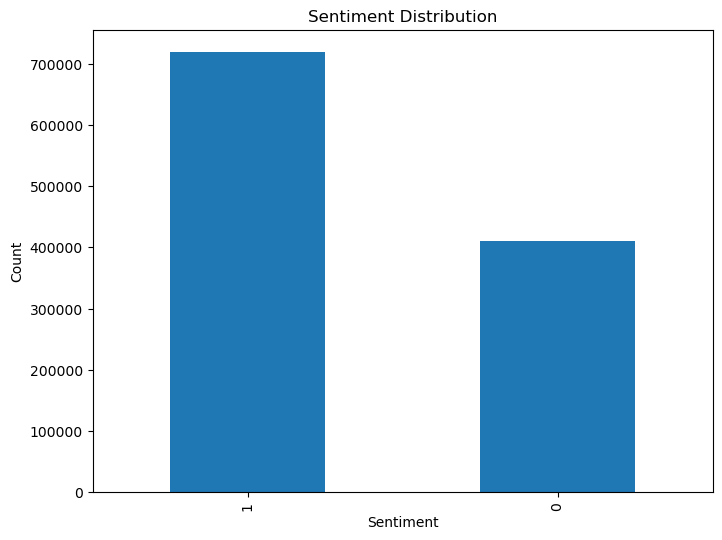

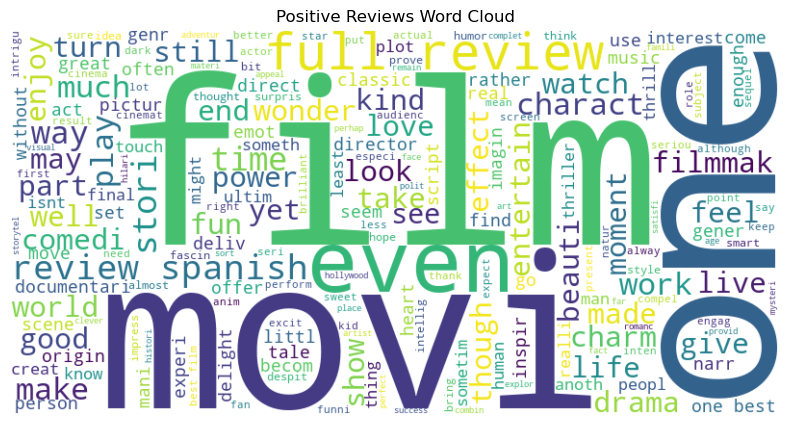

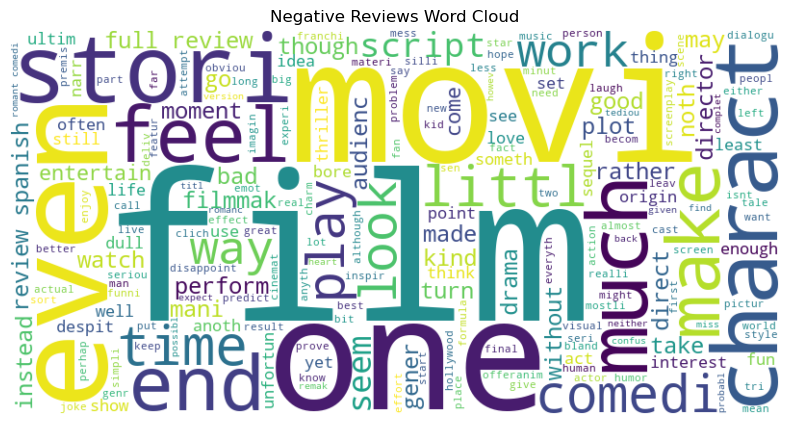

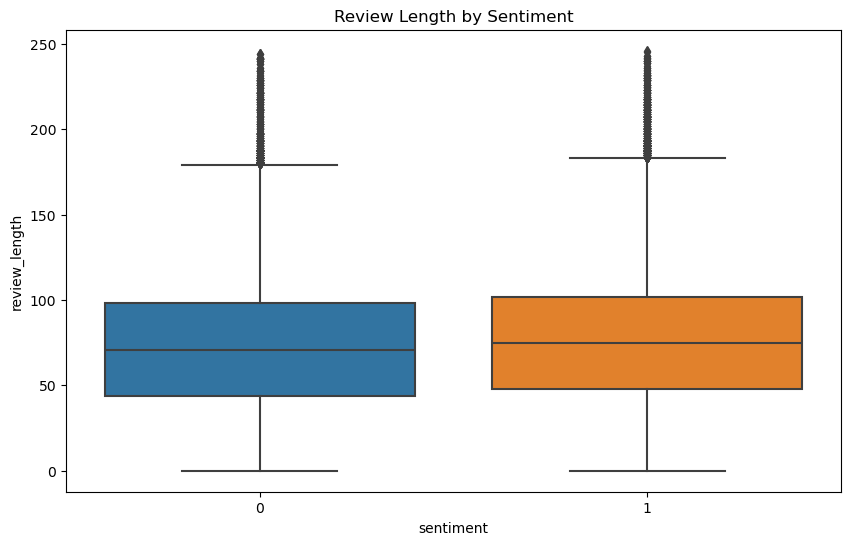

In [17]:
# Sentiment distribution
plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word cloud for positive and negative reviews
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_text = ' '.join(df[df['sentiment'] == 1]['processed_review'])
negative_text = ' '.join(df[df['sentiment'] == 0]['processed_review'])

plot_wordcloud(positive_text, 'Positive Reviews Word Cloud')
plot_wordcloud(negative_text, 'Negative Reviews Word Cloud')

# Review length analysis
df['review_length'] = df['processed_review'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

Fitting the SVM model...
Making predictions...

SVM Model Evaluation:
Accuracy: 0.7873

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.60      0.67     81764
           1       0.80      0.89      0.84    144214

    accuracy                           0.79    225978
   macro avg       0.78      0.75      0.76    225978
weighted avg       0.78      0.79      0.78    225978



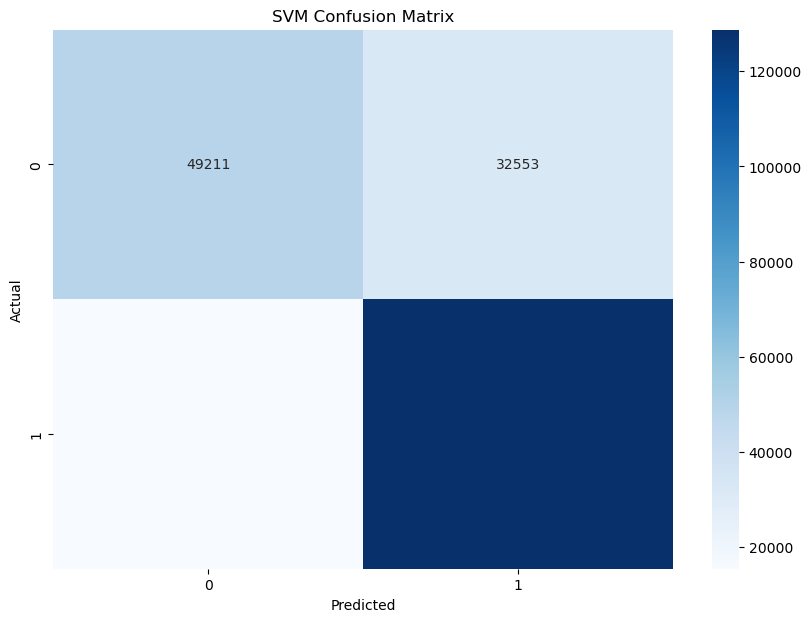

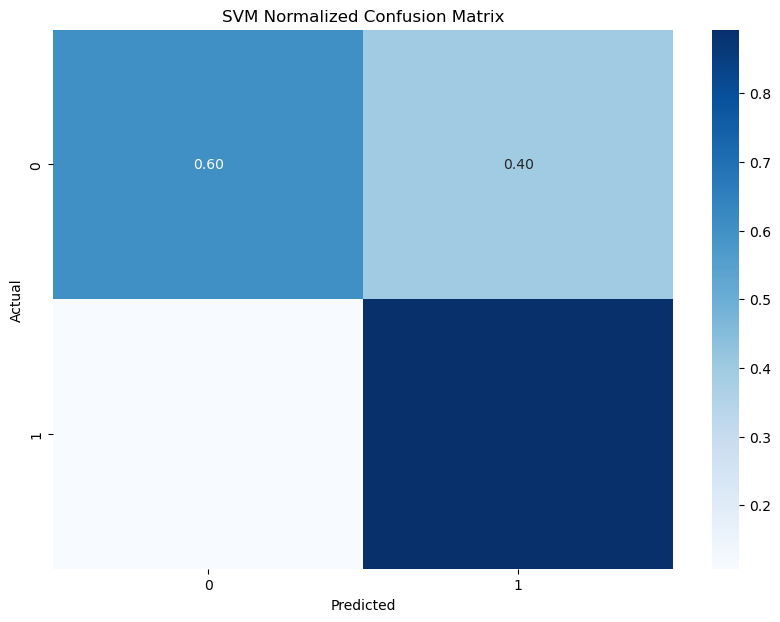

Fitting the Naive Bayes model...
Making predictions...

Naive Bayes Model Evaluation:
Accuracy: 0.7776

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68     81764
           1       0.81      0.85      0.83    144214

    accuracy                           0.78    225978
   macro avg       0.76      0.75      0.75    225978
weighted avg       0.77      0.78      0.78    225978



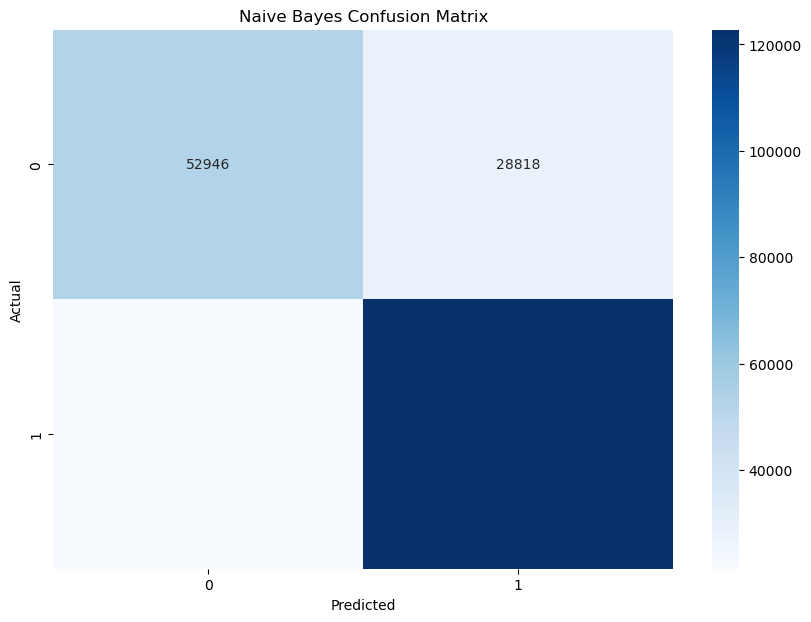

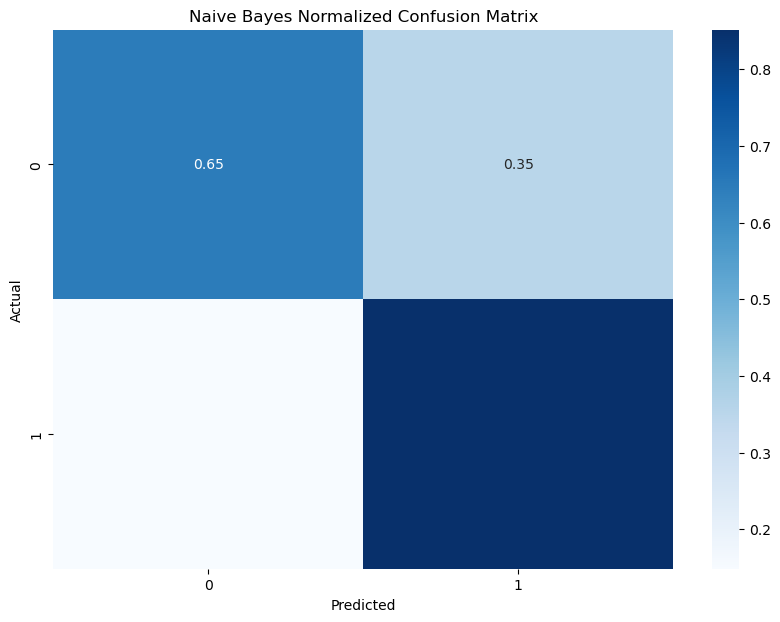

Fitting the Logistic Regression model...
Making predictions...

Logistic Regression Model Evaluation:
Accuracy: 0.7884

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.61      0.68     81764
           1       0.80      0.89      0.84    144214

    accuracy                           0.79    225978
   macro avg       0.78      0.75      0.76    225978
weighted avg       0.79      0.79      0.78    225978



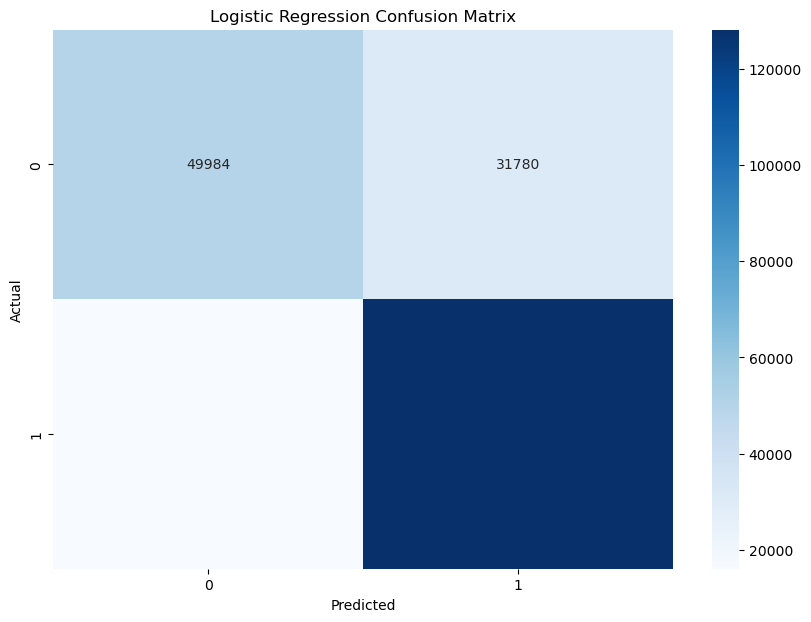

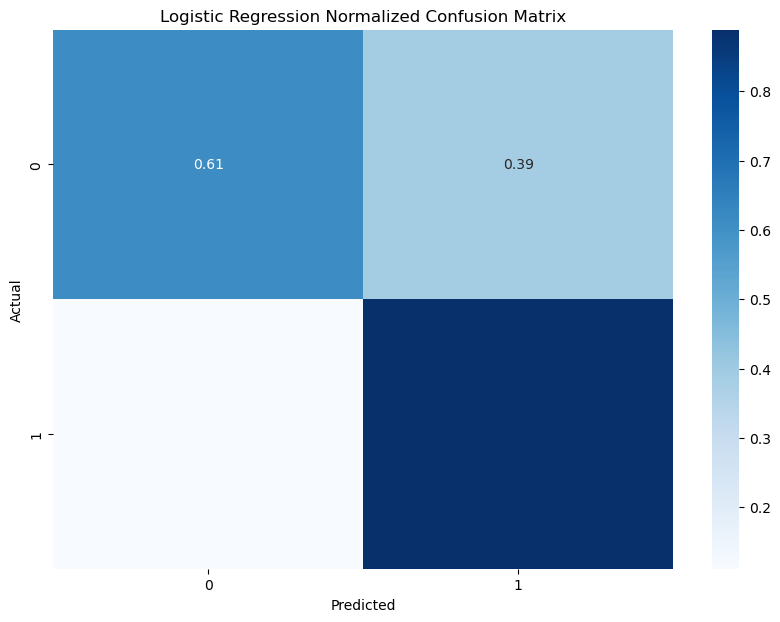

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Split the data
X = df['processed_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_evaluate_model(model, model_name):
    # Create pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=10000)),
        ('classifier', model)
    ])

    # Fit the model
    print(f"Fitting the {model_name} model...")
    pipeline.fit(X_train, y_train)

    # Make predictions
    print("Making predictions...")
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    print(f"\n{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{model_name} Normalized Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Train and evaluate SVM
svm_model = LinearSVC(dual=False, max_iter=1000)
train_evaluate_model(svm_model, "SVM")

# Train and evaluate Naive Bayes
nb_model = MultinomialNB()
train_evaluate_model(nb_model, "Naive Bayes")

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
train_evaluate_model(lr_model, "Logistic Regression")

Fitting the SVM model...
Making predictions...

SVM Model Evaluation:
Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.61      0.68     81764
           1       0.80      0.89      0.84    144214

    accuracy                           0.79    225978
   macro avg       0.78      0.75      0.76    225978
weighted avg       0.79      0.79      0.78    225978



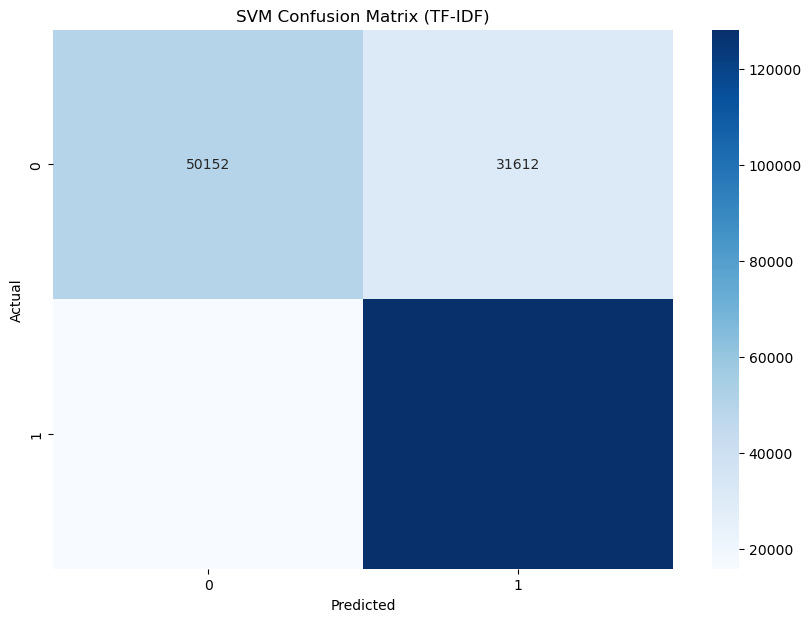

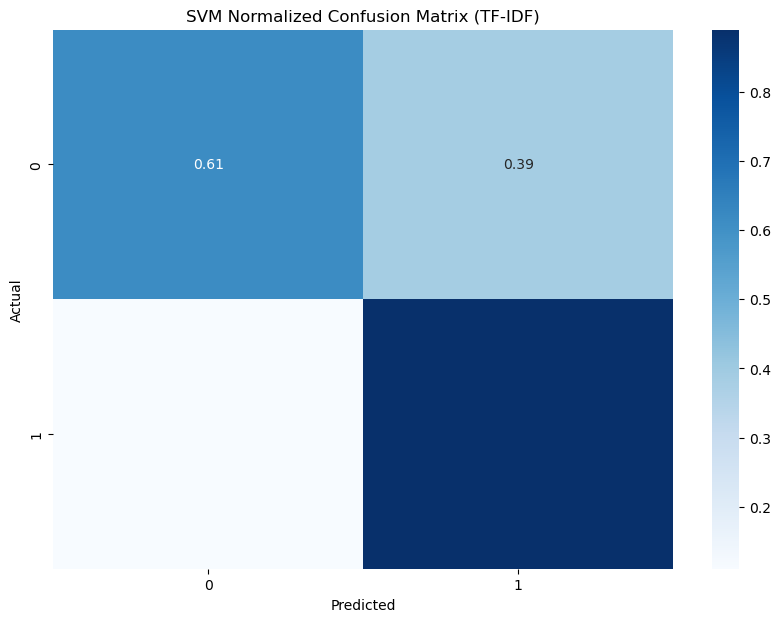

Fitting the Naive Bayes model...
Making predictions...

Naive Bayes Model Evaluation:
Accuracy: 0.7655

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.47      0.59     81764
           1       0.76      0.94      0.84    144214

    accuracy                           0.77    225978
   macro avg       0.78      0.70      0.71    225978
weighted avg       0.77      0.77      0.75    225978



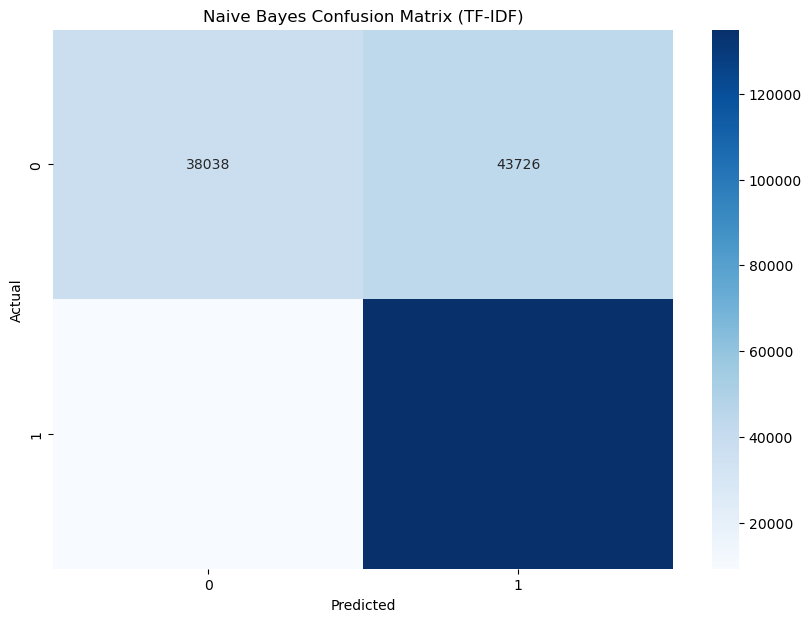

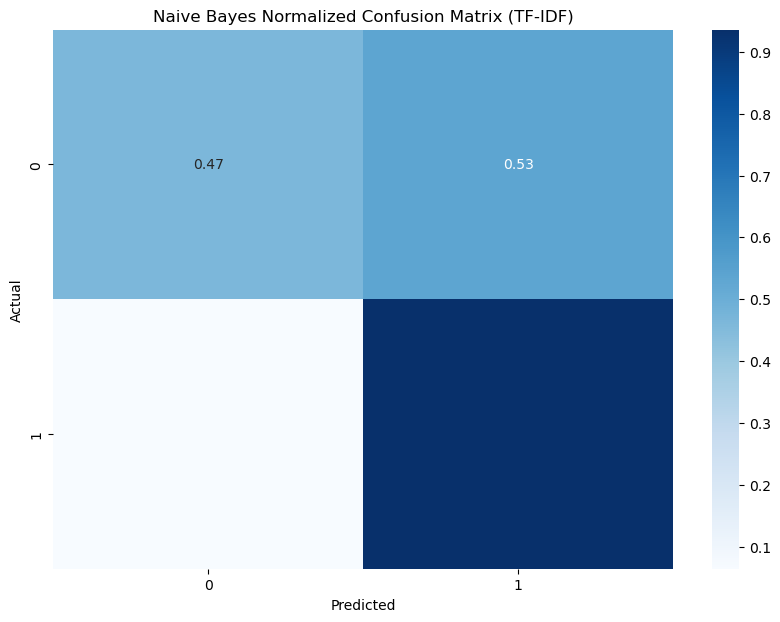

Fitting the Logistic Regression model...
Making predictions...

Logistic Regression Model Evaluation:
Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.61      0.68     81764
           1       0.80      0.89      0.84    144214

    accuracy                           0.79    225978
   macro avg       0.78      0.75      0.76    225978
weighted avg       0.79      0.79      0.78    225978



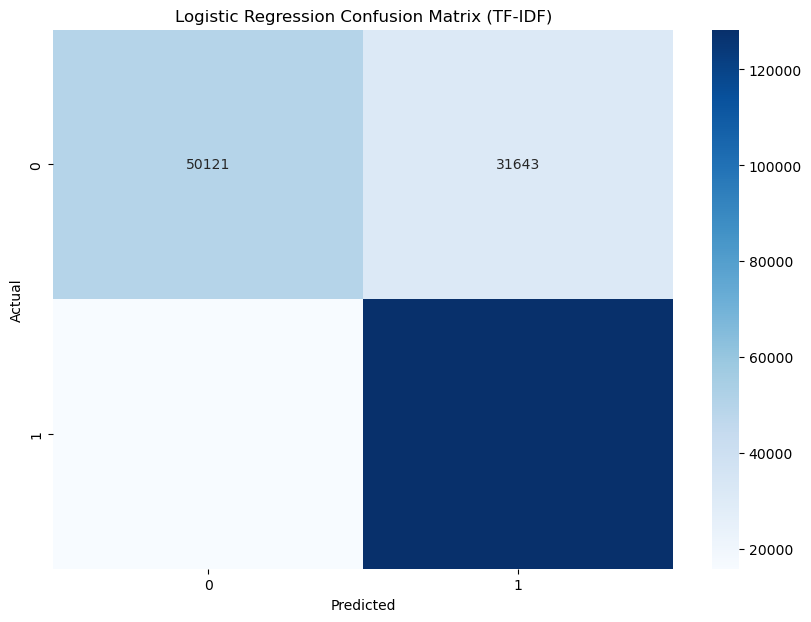

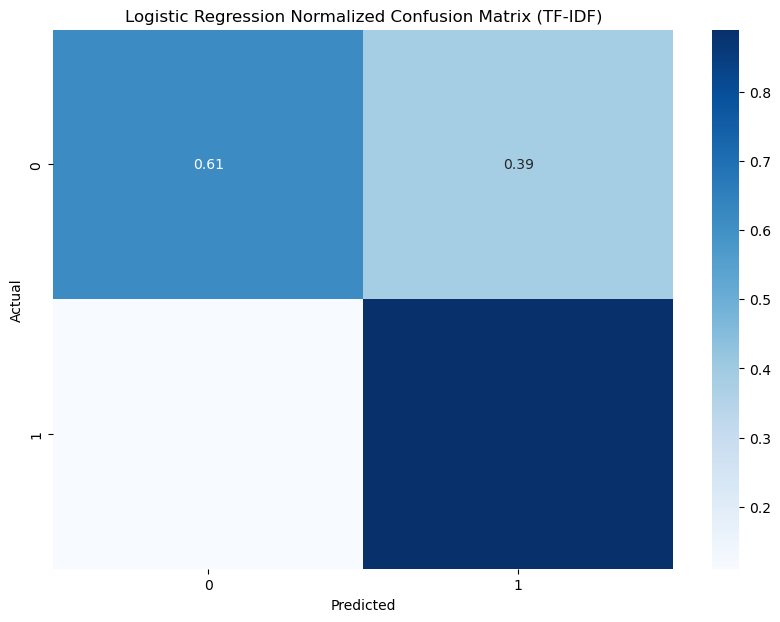

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Split the data
X = df['processed_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_evaluate_model(model, model_name):
    # Create pipeline with TfidfVectorizer
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=10000)),
        ('classifier', model)
    ])

    # Fit the model
    print(f"Fitting the {model_name} model...")
    pipeline.fit(X_train, y_train)

    # Make predictions
    print("Making predictions...")
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    print(f"\n{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix (TF-IDF)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{model_name} Normalized Confusion Matrix (TF-IDF)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Train and evaluate SVM
svm_model = LinearSVC(dual=False, max_iter=1000)
train_evaluate_model(svm_model, "SVM")

# Train and evaluate Naive Bayes
nb_model = MultinomialNB()
train_evaluate_model(nb_model, "Naive Bayes")

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
train_evaluate_model(lr_model, "Logistic Regression")

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Assuming df, X, y are already defined as in previous examples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model (using Logistic Regression as an example)
model = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000)),
    ('classifier', LogisticRegression(max_iter=1000))
])
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Create a DataFrame with test data, true labels, and predictions
error_df = pd.DataFrame({
    'text': X_test,
    'true_sentiment': y_test,
    'predicted_sentiment': y_pred
})

# Add a column to flag errors
error_df['is_error'] = error_df['true_sentiment'] != error_df['predicted_sentiment']

# Function to get most influential features for a prediction
def get_influential_features(text, n=10):
    # Transform the text using the fitted vectorizer
    feature_vector = model.named_steps['vectorizer'].transform([text])
    
    # Get feature names
    feature_names = model.named_steps['vectorizer'].get_feature_names_out()
    
    # Get coefficients from the model
    coefficients = model.named_steps['classifier'].coef_[0]
    
    # Calculate the influence of each feature
    influences = feature_vector.multiply(coefficients).toarray()[0]
    
    # Sort features by absolute influence
    sorted_idx = np.argsort(np.abs(influences))[::-1]
    
    # Return top n influential features and their influences
    top_features = [(feature_names[i], influences[i]) for i in sorted_idx[:n]]
    return top_features

# Analyze errors
print("Total errors:", error_df['is_error'].sum())
print("\nMost common misclassified examples:")
for sentiment in [0, 1]:
    print(f"\nMisclassified as {sentiment}:")
    misclassified = error_df[(error_df['is_error']) & (error_df['predicted_sentiment'] == sentiment)].head(5)
    for idx, row in misclassified.iterrows():
        print(f"\nTrue sentiment: {row['true_sentiment']}")
        print(f"Text: {row['text'][:100]}...")  # Print first 100 characters
        print("Top influential features:")
        for feature, influence in get_influential_features(row['text']):
            print(f"  {feature}: {influence:.4f}")
        print()

# Analyze feature importance overall
vectorizer = model.named_steps['vectorizer']
classifier = model.named_steps['classifier']

feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]

# Sort features by their absolute coefficient values
sorted_idx = np.argsort(np.abs(coefficients))[::-1]

print("\nTop 20 most important features overall:")
for idx in sorted_idx[:20]:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

Total errors: 47579

Most common misclassified examples:

Misclassified as 0:

True sentiment: 1
Text: gigant best appreci kooki cast chemistri stori like lure plump orthoped mattress stock essenti painl...
Top influential features:
  snooz: -1.6207
  best: 0.6181
  appreci: 0.4565
  stock: -0.2346
  chemistri: 0.1937
  kooki: -0.1589
  gigant: -0.1301
  essenti: 0.0896
  lure: -0.0885
  like: -0.0851


True sentiment: 1
Text: wild ride never never commit crime dull...
Top influential features:
  dull: -2.0114
  never: -0.7980
  ride: 0.5777
  wild: 0.3889
  crime: 0.1081
  commit: 0.0267
  flimsi: 0.0000
  flinch: 0.0000
  fling: 0.0000
  flip: 0.0000


True sentiment: 1
Text: compel stori troubl isnt terribl visual stori documentari doesnt serv nearli well book lengthi artic...
Top influential features:
  terribl: -0.7987
  documentari: 0.7397
  doesnt: -0.4937
  isnt: -0.4579
  compel: 0.4416
  would: -0.4373
  troubl: -0.3844
  well: 0.3506
  nearli: -0.3472
  book: -0.1365


True 

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

def analyze_errors(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} Error Analysis:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    error_df = pd.DataFrame({'text': X_test, 'true': y_test, 'pred': y_pred})
    error_df['is_error'] = error_df['true'] != error_df['pred']
    
    print("\nMost common misclassifications:")
    for true_label in [0, 1]:
        misclassified = error_df[(error_df['is_error']) & (error_df['true'] == true_label)].head(3)
        print(f"\nTrue label: {true_label}")
        for _, row in misclassified.iterrows():
            print(f"Predicted: {row['pred']}")
            print(f"Text: {row['text'][:100]}...")
    
    feature_names = model.named_steps['vectorizer'].get_feature_names_out()
    if isinstance(model.named_steps['classifier'], LinearSVC):
        coefficients = model.named_steps['classifier'].coef_[0]
    else:  # Naive Bayes
        coefficients = model.named_steps['classifier'].feature_log_prob_[1] - model.named_steps['classifier'].feature_log_prob_[0]
    
    top_features = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)[:10]
    print("\nTop 10 most important features:")
    for feature, coef in top_features:
        print(f"{feature}: {coef:.4f}")

# Assuming X, y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes
nb_model = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000)),
    ('classifier', MultinomialNB())
])
nb_model.fit(X_train, y_train)
analyze_errors(nb_model, "Naive Bayes", X_test, y_test)

# SVM
svm_model = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000)),
    ('classifier', LinearSVC(dual=False, max_iter=1000))
])
svm_model.fit(X_train, y_train)
analyze_errors(svm_model, "SVM", X_test, y_test)


Naive Bayes Error Analysis:
              precision    recall  f1-score   support

           0       0.80      0.47      0.59     81764
           1       0.76      0.94      0.84    144214

    accuracy                           0.77    225978
   macro avg       0.78      0.70      0.71    225978
weighted avg       0.77      0.77      0.75    225978

Confusion Matrix:
[[ 38038  43726]
 [  9271 134943]]

Most common misclassifications:

True label: 0
Predicted: 1
Text: there noth quit like death famili evok romant feel comed chuckl us...
Predicted: 1
Text: avoid cost...
Predicted: 1
Text: gener way environ work drain materi uniqu leav urban twist despit tightli coil perform...

True label: 1
Predicted: 0
Text: gigant best appreci kooki cast chemistri stori like lure plump orthoped mattress stock essenti painl...
Predicted: 0
Text: wild ride never never commit crime dull...
Predicted: 0
Text: compel stori troubl isnt terribl visual stori documentari doesnt serv nearli well book length